# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

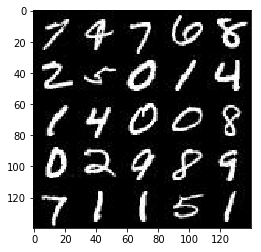

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

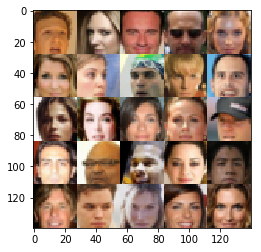

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # real input
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learn_rate = tf.placeholder(tf.float32, name = 'learn_rate')
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/nick/anaconda3/envs/facegen/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/nick/anaconda3/envs/facegen/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/nick/anaconda3/envs/facegen/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/nick/anaconda3/envs/facegen/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/nick/anaconda3/envs/facegen/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/nic

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [29]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse = reuse):
        # images are 28x28x3
        # no batch normalization on first layer
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        #print("x1 shape: {}".format(x1))
        x2 = tf.layers.conv2d(x1, 128, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        #print("x2 shape: {}".format(x2))
        x3 = tf.layers.conv2d(x2, 256, 4, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        #print("x3 shape: {}".format(x3))
        x4 = tf.layers.conv2d(x3, 256, 2, strides = 2, padding = 'same')
        x4 = tf.layers.batch_normalization(x4, training = True)
        x4 = tf.maximum(alpha * x4, x4)
        # 2x2x512
        #print("x4 shape: {}".format(x4))
        
        # flatten
        _, w, h, d = x4.get_shape().as_list()
        flat = tf.reshape(x4, (-1, w*h*d))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2 * 2 * 512)
        # project and reshape
        x1 = tf.reshape(x1, (-1,2,2,512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(x1 * alpha, x1)
        # now 2x2x1024
        #print('x1 shape: {}, expect 2x2x1024'.format(x1.get_shape()))
        
        # second layer
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(x2 * alpha, x2)
        # now 4x4x512
        #print('x2 shape: {}, expect 4x4x512'.format(x2.get_shape()))

        # third layer. use valid padding to get 7x7 instead of 8x8 since we want final dimensions 28x28
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides = 1, padding = 'valid')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(x3 * alpha, x3)
        # now 7x7x256
        #print('x3 shape: {}, expect 7x7x256'.format(x3.get_shape()))
        
        # intermediate layer with kernel size of 5, same as other layers
        # but stride of 1 to keep same dimensions
        x31 = tf.layers.conv2d_transpose(x3, 128, 5, strides = 1, padding = 'valid')
        x31 = tf.layers.batch_normalization(x31, training = is_train)
        x31 = tf.maximum(x31 * alpha, x31)
        # now 7x7x256
        #print('x31 shape: {}, expect 7x7x256'.format(x31.get_shape()))
        
        # fourth layer.
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides = 2, padding = 'same')
        x4 = tf.layers.batch_normalization(x4, training = is_train)
        x4 = tf.maximum(x4 * alpha, x4)
        # now 14x14x128
        #print('x4 shape: {}, expect 14x14x128'.format(x4.get_shape()))
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides = 2, padding = 'same')
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(z=input_z, out_channel_dim=out_channel_dim)
    d_model_real, d_logits_real = discriminator(images=input_real)
    d_model_fake, d_logits_fake = discriminator(images=g_model, reuse=True)

    # label smoothing, for discriminator
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
                                                                         labels = tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                         labels = tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                    labels = tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
        
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # get variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize !
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # check image mode, should be RGB or L for greyscale
    if data_image_mode == "RGB":
        image_channels = 3
    elif data_image_mode == "L":
        image_channels = 1
    else:
        raise ValueError('data_image_mode not suported: "{}" (expected RGB or L)'.format(data_image_mode))
    # end if elif else
    
    # build model
    #print("building model. data_shape = {}".format(data_shape))
    input_real, input_z, lr = model_inputs(image_width = data_shape[1],
                                           image_height = data_shape[2],
                                           image_channels = image_channels,
                                           z_dim = z_dim)
    d_loss, g_loss = model_loss(input_real = input_real,
                                input_z = input_z,
                                out_channel_dim = image_channels)
    d_opt, g_opt = model_opt(d_loss = d_loss,
                             g_loss = g_loss, 
                             learning_rate = lr,
                             beta1 = beta1)
    # create variables for saving checkpoints
    #saver = tf.train.Saver()
    
    losses = []
    steps = 0
    print_every = 10
    show_every = 100
    # train the model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # rescale 
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                
                # sample random noise for the generator
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                # run optimizers (in parallel)
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                # print losses periodically
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                # end if
                # show some generated samples periodically
                if steps % show_every == 0:
                    show_generator_output(sess = sess, 
                                          input_z = input_z, 
                                          out_channel_dim = image_channels, 
                                          image_mode = data_image_mode,
                                          n_images = 25)
                # end if
            # end for
        # end for
    # end with
    # plot the losses
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
# end def

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3697... Generator Loss: 5.8172
Epoch 1/2... Discriminator Loss: 0.4971... Generator Loss: 2.2374
Epoch 1/2... Discriminator Loss: 0.8804... Generator Loss: 1.1617
Epoch 1/2... Discriminator Loss: 1.3366... Generator Loss: 9.5132
Epoch 1/2... Discriminator Loss: 0.4348... Generator Loss: 3.0896
Epoch 1/2... Discriminator Loss: 0.5428... Generator Loss: 2.2009
Epoch 1/2... Discriminator Loss: 0.4170... Generator Loss: 5.7083
Epoch 1/2... Discriminator Loss: 0.4056... Generator Loss: 2.9274
Epoch 1/2... Discriminator Loss: 0.4829... Generator Loss: 2.4858
Epoch 1/2... Discriminator Loss: 0.4585... Generator Loss: 2.4287


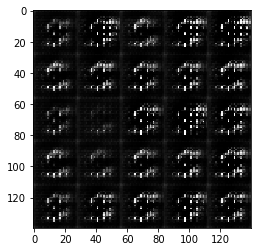

Epoch 1/2... Discriminator Loss: 1.9944... Generator Loss: 5.2762
Epoch 1/2... Discriminator Loss: 0.6773... Generator Loss: 1.3950
Epoch 1/2... Discriminator Loss: 0.4640... Generator Loss: 2.5477
Epoch 1/2... Discriminator Loss: 0.5247... Generator Loss: 6.7607
Epoch 1/2... Discriminator Loss: 0.5234... Generator Loss: 2.3264
Epoch 1/2... Discriminator Loss: 0.7254... Generator Loss: 1.3137
Epoch 1/2... Discriminator Loss: 0.4716... Generator Loss: 2.8167
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 1.0773
Epoch 1/2... Discriminator Loss: 0.4207... Generator Loss: 5.5658
Epoch 1/2... Discriminator Loss: 1.1870... Generator Loss: 5.3264


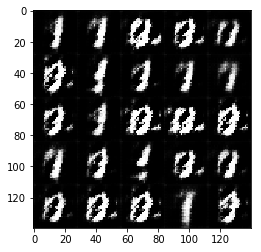

Epoch 1/2... Discriminator Loss: 0.5046... Generator Loss: 3.8054
Epoch 1/2... Discriminator Loss: 0.5166... Generator Loss: 3.3352
Epoch 1/2... Discriminator Loss: 0.4364... Generator Loss: 3.5269
Epoch 1/2... Discriminator Loss: 0.7188... Generator Loss: 2.1295
Epoch 1/2... Discriminator Loss: 0.5383... Generator Loss: 1.8069
Epoch 1/2... Discriminator Loss: 0.6058... Generator Loss: 1.8330
Epoch 1/2... Discriminator Loss: 0.5870... Generator Loss: 2.4739
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.2808
Epoch 1/2... Discriminator Loss: 1.8624... Generator Loss: 4.4632
Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 0.9356


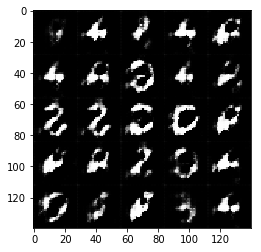

Epoch 1/2... Discriminator Loss: 0.8100... Generator Loss: 3.6695
Epoch 1/2... Discriminator Loss: 0.5125... Generator Loss: 2.6854
Epoch 1/2... Discriminator Loss: 0.5408... Generator Loss: 1.9882
Epoch 1/2... Discriminator Loss: 0.5486... Generator Loss: 2.1603
Epoch 1/2... Discriminator Loss: 0.7099... Generator Loss: 1.6099
Epoch 1/2... Discriminator Loss: 0.7517... Generator Loss: 1.4425
Epoch 1/2... Discriminator Loss: 0.5757... Generator Loss: 1.9917
Epoch 1/2... Discriminator Loss: 0.7165... Generator Loss: 1.4499
Epoch 1/2... Discriminator Loss: 0.7437... Generator Loss: 1.3428
Epoch 1/2... Discriminator Loss: 0.7821... Generator Loss: 1.5144


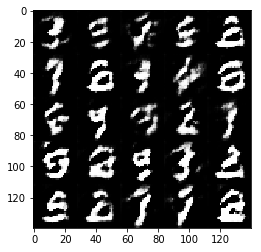

Epoch 1/2... Discriminator Loss: 0.6381... Generator Loss: 1.6958
Epoch 1/2... Discriminator Loss: 0.6600... Generator Loss: 2.2486
Epoch 1/2... Discriminator Loss: 0.5913... Generator Loss: 2.2481
Epoch 1/2... Discriminator Loss: 0.6572... Generator Loss: 2.2468
Epoch 1/2... Discriminator Loss: 0.6257... Generator Loss: 2.2550
Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 0.9996
Epoch 1/2... Discriminator Loss: 0.7538... Generator Loss: 1.4426
Epoch 1/2... Discriminator Loss: 0.6864... Generator Loss: 2.5052
Epoch 1/2... Discriminator Loss: 0.8167... Generator Loss: 1.2540
Epoch 1/2... Discriminator Loss: 0.6635... Generator Loss: 2.3593


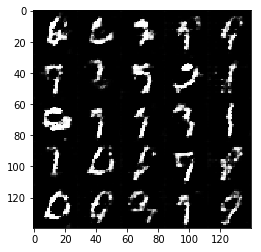

Epoch 1/2... Discriminator Loss: 0.7592... Generator Loss: 1.5319
Epoch 1/2... Discriminator Loss: 0.7354... Generator Loss: 2.0433
Epoch 1/2... Discriminator Loss: 0.6389... Generator Loss: 2.4777
Epoch 1/2... Discriminator Loss: 0.8041... Generator Loss: 1.8785
Epoch 1/2... Discriminator Loss: 0.7408... Generator Loss: 1.7355
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 1.0505
Epoch 1/2... Discriminator Loss: 0.7685... Generator Loss: 1.4315
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 1.3206
Epoch 1/2... Discriminator Loss: 1.3123... Generator Loss: 0.6018
Epoch 1/2... Discriminator Loss: 0.7623... Generator Loss: 1.6786


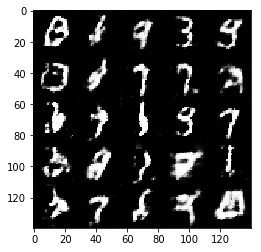

Epoch 1/2... Discriminator Loss: 0.7749... Generator Loss: 1.6657
Epoch 1/2... Discriminator Loss: 0.7548... Generator Loss: 1.5593
Epoch 1/2... Discriminator Loss: 0.7343... Generator Loss: 1.5605
Epoch 1/2... Discriminator Loss: 0.8151... Generator Loss: 1.5596
Epoch 1/2... Discriminator Loss: 0.9631... Generator Loss: 2.2964
Epoch 1/2... Discriminator Loss: 0.8662... Generator Loss: 1.4506
Epoch 1/2... Discriminator Loss: 0.9408... Generator Loss: 1.0688
Epoch 1/2... Discriminator Loss: 0.8078... Generator Loss: 1.2868
Epoch 1/2... Discriminator Loss: 0.9190... Generator Loss: 0.9926
Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 0.9774


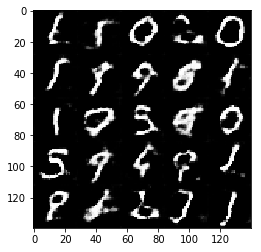

Epoch 1/2... Discriminator Loss: 0.8341... Generator Loss: 1.4453
Epoch 1/2... Discriminator Loss: 0.8014... Generator Loss: 1.6901
Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 2.3071
Epoch 1/2... Discriminator Loss: 0.9774... Generator Loss: 0.9975
Epoch 1/2... Discriminator Loss: 0.9117... Generator Loss: 1.0329
Epoch 1/2... Discriminator Loss: 0.9364... Generator Loss: 1.5654
Epoch 1/2... Discriminator Loss: 1.6264... Generator Loss: 0.4041
Epoch 1/2... Discriminator Loss: 0.7387... Generator Loss: 1.6579
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 1.0190
Epoch 1/2... Discriminator Loss: 0.8750... Generator Loss: 3.2597


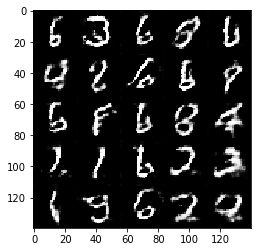

Epoch 1/2... Discriminator Loss: 0.7601... Generator Loss: 2.1682
Epoch 1/2... Discriminator Loss: 1.1835... Generator Loss: 3.1809
Epoch 1/2... Discriminator Loss: 0.7531... Generator Loss: 1.5470
Epoch 1/2... Discriminator Loss: 1.0271... Generator Loss: 0.9196
Epoch 1/2... Discriminator Loss: 1.3060... Generator Loss: 0.5584
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 0.8535
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 0.7937... Generator Loss: 1.5002
Epoch 1/2... Discriminator Loss: 1.4261... Generator Loss: 3.8230
Epoch 1/2... Discriminator Loss: 0.7741... Generator Loss: 2.1898


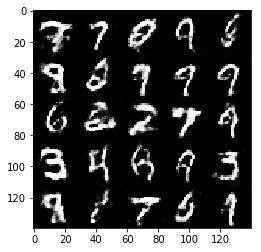

Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 1.1872
Epoch 1/2... Discriminator Loss: 0.8897... Generator Loss: 1.0982
Epoch 1/2... Discriminator Loss: 1.1131... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 0.9938... Generator Loss: 0.9457
Epoch 1/2... Discriminator Loss: 1.2090... Generator Loss: 0.6889
Epoch 1/2... Discriminator Loss: 1.1027... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 0.8511... Generator Loss: 1.0375
Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 0.6547
Epoch 1/2... Discriminator Loss: 0.8943... Generator Loss: 1.0008
Epoch 1/2... Discriminator Loss: 0.8369... Generator Loss: 1.2977


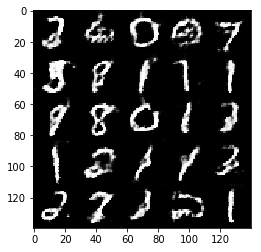

Epoch 1/2... Discriminator Loss: 1.1692... Generator Loss: 0.7579
Epoch 1/2... Discriminator Loss: 0.7766... Generator Loss: 1.2833
Epoch 1/2... Discriminator Loss: 0.7174... Generator Loss: 1.6501
Epoch 1/2... Discriminator Loss: 2.0444... Generator Loss: 3.1552
Epoch 1/2... Discriminator Loss: 0.9071... Generator Loss: 0.9993
Epoch 1/2... Discriminator Loss: 0.7836... Generator Loss: 2.0225
Epoch 1/2... Discriminator Loss: 1.1751... Generator Loss: 0.6551
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 0.6525
Epoch 1/2... Discriminator Loss: 1.5784... Generator Loss: 3.4713
Epoch 1/2... Discriminator Loss: 0.7984... Generator Loss: 1.4022


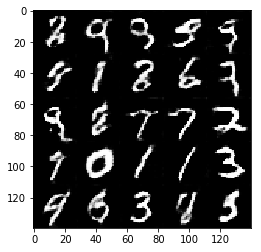

Epoch 1/2... Discriminator Loss: 1.3011... Generator Loss: 0.5776
Epoch 1/2... Discriminator Loss: 1.7393... Generator Loss: 0.3580
Epoch 1/2... Discriminator Loss: 0.9165... Generator Loss: 0.9706
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 1.1163
Epoch 1/2... Discriminator Loss: 0.9094... Generator Loss: 1.3080
Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 1.7848
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 1.1409
Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 1.4878
Epoch 1/2... Discriminator Loss: 2.2034... Generator Loss: 0.2166
Epoch 1/2... Discriminator Loss: 1.0066... Generator Loss: 0.9713


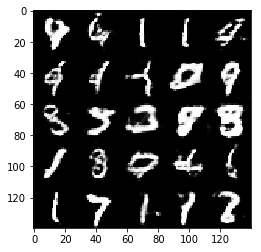

Epoch 2/2... Discriminator Loss: 1.4023... Generator Loss: 0.5049
Epoch 2/2... Discriminator Loss: 0.7376... Generator Loss: 1.5312
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 2.1260
Epoch 2/2... Discriminator Loss: 1.6952... Generator Loss: 0.4041
Epoch 2/2... Discriminator Loss: 0.7309... Generator Loss: 1.2752
Epoch 2/2... Discriminator Loss: 0.8744... Generator Loss: 1.9878
Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.5181
Epoch 2/2... Discriminator Loss: 0.7892... Generator Loss: 1.2076
Epoch 2/2... Discriminator Loss: 0.9849... Generator Loss: 0.8783
Epoch 2/2... Discriminator Loss: 1.4652... Generator Loss: 0.4286


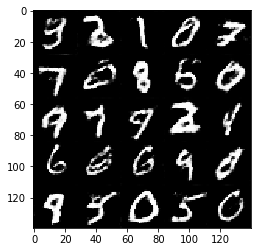

Epoch 2/2... Discriminator Loss: 0.6910... Generator Loss: 1.9617
Epoch 2/2... Discriminator Loss: 1.8686... Generator Loss: 0.3830
Epoch 2/2... Discriminator Loss: 1.2935... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 1.2349
Epoch 2/2... Discriminator Loss: 1.0307... Generator Loss: 0.8886
Epoch 2/2... Discriminator Loss: 0.7710... Generator Loss: 1.2952
Epoch 2/2... Discriminator Loss: 0.7377... Generator Loss: 1.3268
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.6572
Epoch 2/2... Discriminator Loss: 0.8323... Generator Loss: 1.2553
Epoch 2/2... Discriminator Loss: 0.9331... Generator Loss: 0.9468


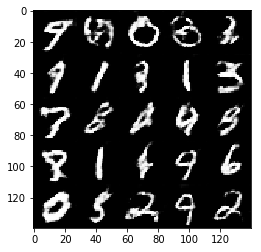

Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 1.0219
Epoch 2/2... Discriminator Loss: 1.1398... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.7191... Generator Loss: 0.3748
Epoch 2/2... Discriminator Loss: 0.8046... Generator Loss: 1.4055
Epoch 2/2... Discriminator Loss: 0.8899... Generator Loss: 0.9957
Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 0.5586
Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 1.4275
Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 0.8148
Epoch 2/2... Discriminator Loss: 1.2191... Generator Loss: 0.5967
Epoch 2/2... Discriminator Loss: 0.8653... Generator Loss: 1.0274


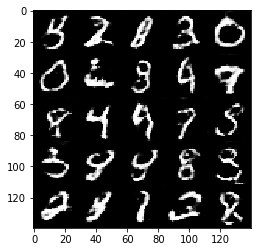

Epoch 2/2... Discriminator Loss: 1.0607... Generator Loss: 0.7648
Epoch 2/2... Discriminator Loss: 0.8876... Generator Loss: 1.3701
Epoch 2/2... Discriminator Loss: 0.9394... Generator Loss: 1.5907
Epoch 2/2... Discriminator Loss: 1.4682... Generator Loss: 0.4777
Epoch 2/2... Discriminator Loss: 0.7321... Generator Loss: 1.2436
Epoch 2/2... Discriminator Loss: 1.6024... Generator Loss: 0.4321
Epoch 2/2... Discriminator Loss: 1.1350... Generator Loss: 0.7531
Epoch 2/2... Discriminator Loss: 0.8145... Generator Loss: 1.2702
Epoch 2/2... Discriminator Loss: 1.5088... Generator Loss: 0.4125
Epoch 2/2... Discriminator Loss: 1.1342... Generator Loss: 0.6680


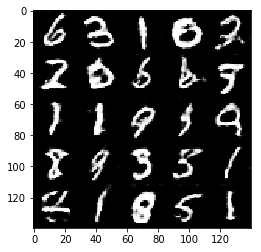

Epoch 2/2... Discriminator Loss: 0.6711... Generator Loss: 2.0651
Epoch 2/2... Discriminator Loss: 0.7782... Generator Loss: 1.4087
Epoch 2/2... Discriminator Loss: 0.7490... Generator Loss: 2.1457
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 0.9472
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 2.3500
Epoch 2/2... Discriminator Loss: 1.6026... Generator Loss: 0.3775
Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 1.5755
Epoch 2/2... Discriminator Loss: 0.7865... Generator Loss: 1.3052
Epoch 2/2... Discriminator Loss: 0.7341... Generator Loss: 1.2666
Epoch 2/2... Discriminator Loss: 0.7268... Generator Loss: 1.3321


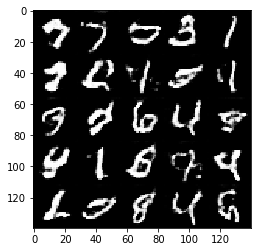

Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 0.9133
Epoch 2/2... Discriminator Loss: 1.4452... Generator Loss: 0.4595
Epoch 2/2... Discriminator Loss: 1.1228... Generator Loss: 0.6586
Epoch 2/2... Discriminator Loss: 0.9504... Generator Loss: 0.8787
Epoch 2/2... Discriminator Loss: 1.2319... Generator Loss: 0.6357
Epoch 2/2... Discriminator Loss: 0.5823... Generator Loss: 1.6988
Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 0.7736
Epoch 2/2... Discriminator Loss: 0.6622... Generator Loss: 1.6107
Epoch 2/2... Discriminator Loss: 1.1935... Generator Loss: 3.2593
Epoch 2/2... Discriminator Loss: 0.7895... Generator Loss: 1.5237


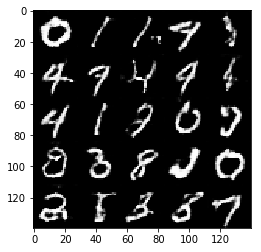

Epoch 2/2... Discriminator Loss: 0.9896... Generator Loss: 0.9414
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 0.9921
Epoch 2/2... Discriminator Loss: 0.9407... Generator Loss: 0.9137
Epoch 2/2... Discriminator Loss: 0.7595... Generator Loss: 1.2873
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 0.6130
Epoch 2/2... Discriminator Loss: 1.6377... Generator Loss: 0.4368
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 0.5908
Epoch 2/2... Discriminator Loss: 1.9767... Generator Loss: 0.2614
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 0.8148
Epoch 2/2... Discriminator Loss: 1.8245... Generator Loss: 0.3373


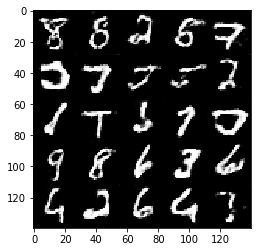

Epoch 2/2... Discriminator Loss: 1.7901... Generator Loss: 0.4143
Epoch 2/2... Discriminator Loss: 0.7799... Generator Loss: 1.4943
Epoch 2/2... Discriminator Loss: 0.6710... Generator Loss: 1.8356
Epoch 2/2... Discriminator Loss: 0.7663... Generator Loss: 1.8618
Epoch 2/2... Discriminator Loss: 0.7468... Generator Loss: 1.2090
Epoch 2/2... Discriminator Loss: 1.4939... Generator Loss: 0.4624
Epoch 2/2... Discriminator Loss: 1.1553... Generator Loss: 0.6939
Epoch 2/2... Discriminator Loss: 1.2692... Generator Loss: 0.6072
Epoch 2/2... Discriminator Loss: 2.9126... Generator Loss: 7.1726
Epoch 2/2... Discriminator Loss: 0.8417... Generator Loss: 1.2912


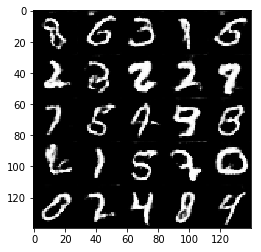

Epoch 2/2... Discriminator Loss: 0.7701... Generator Loss: 1.4272
Epoch 2/2... Discriminator Loss: 0.7388... Generator Loss: 1.6088
Epoch 2/2... Discriminator Loss: 1.1945... Generator Loss: 0.6365
Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 0.9002
Epoch 2/2... Discriminator Loss: 0.7887... Generator Loss: 2.5537
Epoch 2/2... Discriminator Loss: 0.9211... Generator Loss: 0.9831
Epoch 2/2... Discriminator Loss: 0.6707... Generator Loss: 1.9795
Epoch 2/2... Discriminator Loss: 0.6276... Generator Loss: 1.5936
Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 0.8605
Epoch 2/2... Discriminator Loss: 0.7672... Generator Loss: 1.2516


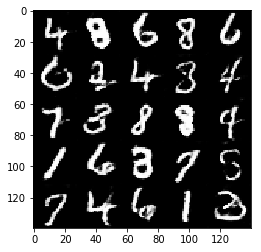

Epoch 2/2... Discriminator Loss: 1.5359... Generator Loss: 0.4764
Epoch 2/2... Discriminator Loss: 1.1065... Generator Loss: 0.6841
Epoch 2/2... Discriminator Loss: 1.0613... Generator Loss: 0.7210
Epoch 2/2... Discriminator Loss: 1.6892... Generator Loss: 4.8233
Epoch 2/2... Discriminator Loss: 1.1004... Generator Loss: 0.6999
Epoch 2/2... Discriminator Loss: 0.7753... Generator Loss: 1.2974
Epoch 2/2... Discriminator Loss: 1.7948... Generator Loss: 3.2990
Epoch 2/2... Discriminator Loss: 0.7800... Generator Loss: 1.1603
Epoch 2/2... Discriminator Loss: 1.1378... Generator Loss: 0.7192
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 0.6809


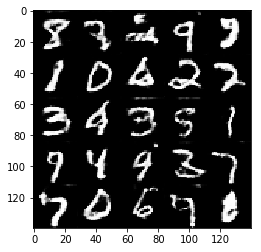

Epoch 2/2... Discriminator Loss: 0.6296... Generator Loss: 1.6791
Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 0.7413
Epoch 2/2... Discriminator Loss: 0.8893... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 0.7279... Generator Loss: 1.3625
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 1.4779
Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 0.5578
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 0.5474
Epoch 2/2... Discriminator Loss: 1.3673... Generator Loss: 0.4997
Epoch 2/2... Discriminator Loss: 0.8358... Generator Loss: 1.1255
Epoch 2/2... Discriminator Loss: 0.6843... Generator Loss: 2.0154


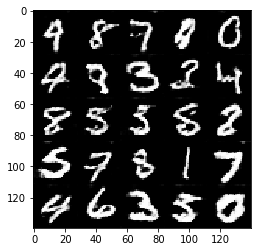

Epoch 2/2... Discriminator Loss: 0.8191... Generator Loss: 1.0162
Epoch 2/2... Discriminator Loss: 0.6523... Generator Loss: 1.6021
Epoch 2/2... Discriminator Loss: 0.6775... Generator Loss: 1.5142
Epoch 2/2... Discriminator Loss: 1.6760... Generator Loss: 0.4016
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 0.5986
Epoch 2/2... Discriminator Loss: 0.8791... Generator Loss: 0.9954
Epoch 2/2... Discriminator Loss: 0.9626... Generator Loss: 0.8994
Epoch 2/2... Discriminator Loss: 0.9372... Generator Loss: 0.9049
Epoch 2/2... Discriminator Loss: 0.7356... Generator Loss: 2.4615
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 1.0067


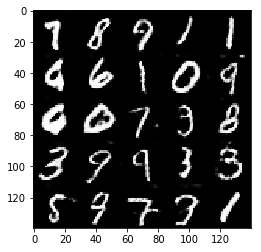

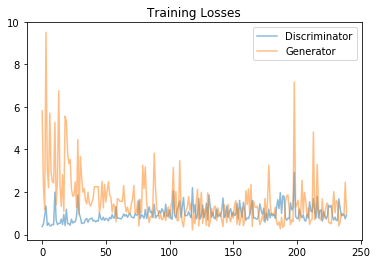

In [32]:
batch_size = 50
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

% matplotlib inline
import matplotlib.pyplot as plt
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.2455... Generator Loss: 0.1850
Epoch 1/1... Discriminator Loss: 3.3343... Generator Loss: 0.0531
Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 6.4023
Epoch 1/1... Discriminator Loss: 1.8416... Generator Loss: 3.8765
Epoch 1/1... Discriminator Loss: 0.7617... Generator Loss: 1.4625
Epoch 1/1... Discriminator Loss: 1.6136... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.1204
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 4.2304
Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 3.8206
Epoch 1/1... Discriminator Loss: 0.5976... Generator Loss: 2.4240


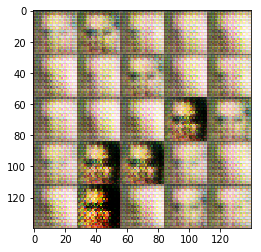

Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 1.6881
Epoch 1/1... Discriminator Loss: 0.5992... Generator Loss: 2.0878
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 0.6465... Generator Loss: 2.4864
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 2.0866
Epoch 1/1... Discriminator Loss: 1.8259... Generator Loss: 0.3599
Epoch 1/1... Discriminator Loss: 1.8424... Generator Loss: 0.2906
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.9729


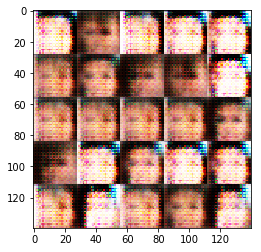

Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 1.1771
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 2.0995
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.9406
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 1.0843


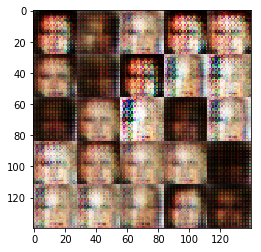

Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.9886
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.8051
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.8103
Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 1.7980
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7555


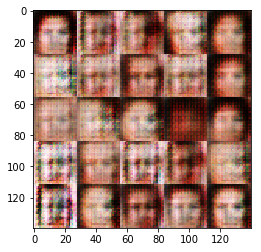

Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.0365
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.7012
Epoch 1/1... Discriminator Loss: 1.7742... Generator Loss: 0.3719
Epoch 1/1... Discriminator Loss: 1.8594... Generator Loss: 0.3121
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 2.0149
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.7022... Generator Loss: 3.2224


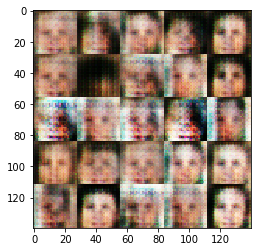

Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 1.1603
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 1.4996
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 3.6536
Epoch 1/1... Discriminator Loss: 0.7121... Generator Loss: 1.9147
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 2.7569
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 0.7364... Generator Loss: 1.8217
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.6008
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.9929
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 1.1472


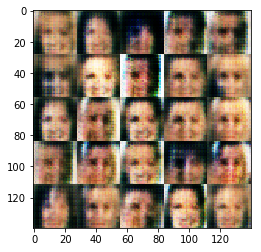

Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 2.2464
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.5710
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.4885
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 2.7815
Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 2.5649
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 1.3653
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 2.8140
Epoch 1/1... Discriminator Loss: 0.6463... Generator Loss: 1.5320


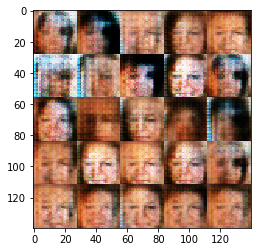

Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 2.8261
Epoch 1/1... Discriminator Loss: 0.7959... Generator Loss: 2.7244
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 2.1220
Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 1.5212
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 1.2843
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 2.4055
Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 2.2209
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 3.1741
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 2.0194
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 3.2824


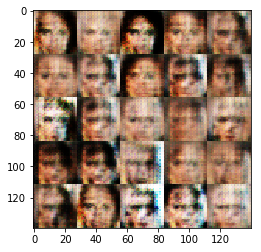

Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 2.1880
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 2.4251
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.4196
Epoch 1/1... Discriminator Loss: 1.6245... Generator Loss: 0.4009
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.3983
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 3.0934
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 0.6813... Generator Loss: 1.6750
Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 2.2610


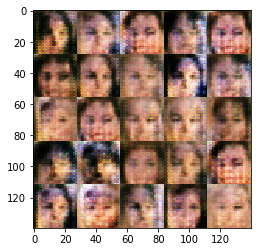

Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.2211
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 0.5796... Generator Loss: 2.0194
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.1709
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 3.5251
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 0.6231... Generator Loss: 2.2410
Epoch 1/1... Discriminator Loss: 0.6565... Generator Loss: 1.6200
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 2.2525
Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 1.6608


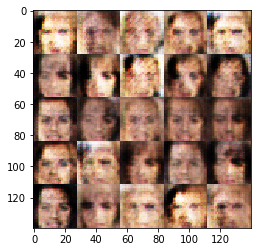

Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.1698
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 3.0234
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.6121
Epoch 1/1... Discriminator Loss: 0.5031... Generator Loss: 2.5769
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 2.5910... Generator Loss: 0.1909
Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 1.8091
Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 1.7122


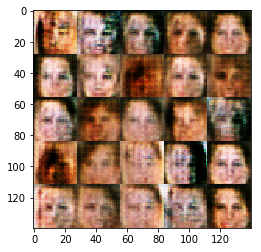

Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 1.4996
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.2628
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 1.5781
Epoch 1/1... Discriminator Loss: 0.6460... Generator Loss: 2.4889
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 1.4168
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 1.1596
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.7545


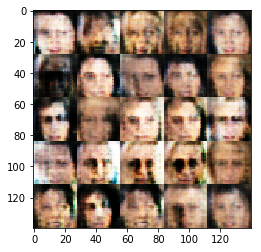

Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 2.6285
Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 1.3359
Epoch 1/1... Discriminator Loss: 0.6874... Generator Loss: 2.4110
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 2.0877
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.9104
Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 2.5219
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 2.2929
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 2.6382
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 3.2905


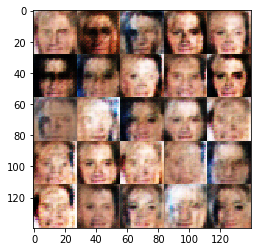

Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 2.1547
Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 1.3992
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 1.9514
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.0603
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 0.5740... Generator Loss: 2.0562
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 2.2256
Epoch 1/1... Discriminator Loss: 0.6928... Generator Loss: 1.6113


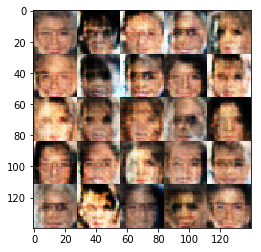

Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.9903
Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 1.4928
Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 1.2900
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 2.7492
Epoch 1/1... Discriminator Loss: 0.7729... Generator Loss: 2.3524
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 0.6623... Generator Loss: 1.5750


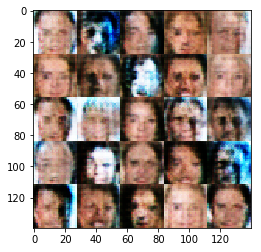

Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.3939
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 2.2155
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 1.4217
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 2.5623
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 2.3524
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 1.9085
Epoch 1/1... Discriminator Loss: 0.7523... Generator Loss: 1.9424
Epoch 1/1... Discriminator Loss: 0.6851... Generator Loss: 1.6695
Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 0.9812


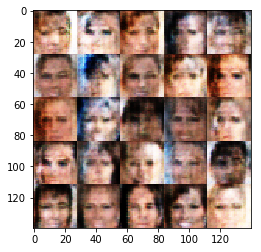

Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 1.3566
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.7049
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.7031... Generator Loss: 0.4375
Epoch 1/1... Discriminator Loss: 0.6522... Generator Loss: 1.5684
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.3803
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 2.6144
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 3.0819
Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 1.5601


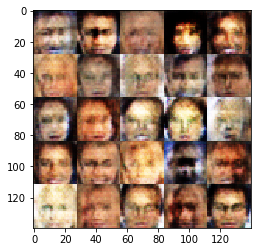

Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 3.0381
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 2.1597
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 1.1225
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 1.9224
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 1.5015
Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 1.6452
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.1515
Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 1.8033


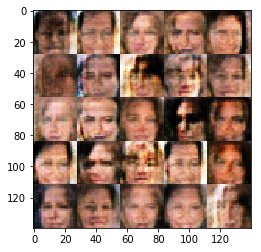

Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 1.5811
Epoch 1/1... Discriminator Loss: 0.6660... Generator Loss: 1.7589
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 2.5653... Generator Loss: 5.7304
Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 2.1545
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 1.5272
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 3.9926
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 2.1466
Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 1.7303


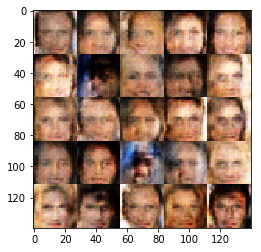

Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.4946
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.3374
Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 2.2948
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 0.6380... Generator Loss: 2.1036
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 3.2002
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.8142
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 1.6981
Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 1.5816


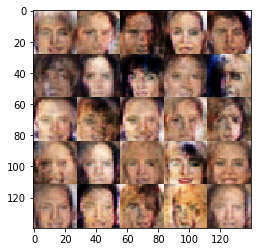

Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 1.5884
Epoch 1/1... Discriminator Loss: 0.8063... Generator Loss: 3.0045
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 1.9512
Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 1.3472
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 3.5137
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 0.7686... Generator Loss: 1.3225


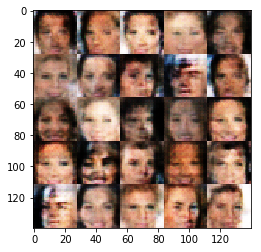

Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 4.0758
Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 1.9140
Epoch 1/1... Discriminator Loss: 0.6435... Generator Loss: 1.5981
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 2.0742
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 1.5068
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.4528
Epoch 1/1... Discriminator Loss: 0.5769... Generator Loss: 2.1674
Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 1.5103


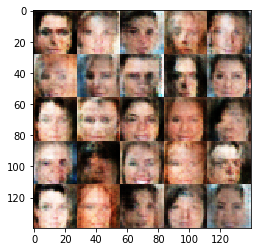

Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 2.0771
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 2.2275
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 2.0320
Epoch 1/1... Discriminator Loss: 1.7791... Generator Loss: 0.4316
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.1130


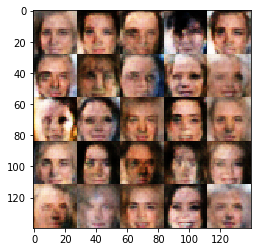

Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 1.3345
Epoch 1/1... Discriminator Loss: 0.5885... Generator Loss: 1.9758
Epoch 1/1... Discriminator Loss: 0.7003... Generator Loss: 1.5826
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 1.4181
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 3.4144
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.6974


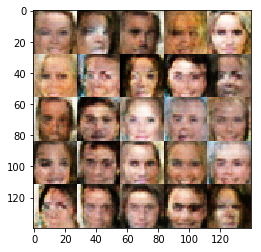

Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.6846
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 3.5594
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.5466
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.7029
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 2.5633
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.7680
Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.2969


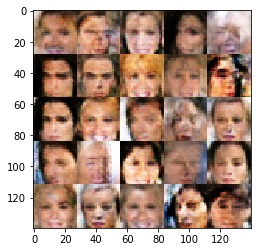

Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 1.2427
Epoch 1/1... Discriminator Loss: 1.6595... Generator Loss: 0.4387
Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 1.3674
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 1.6128
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 1.5355
Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 0.9839


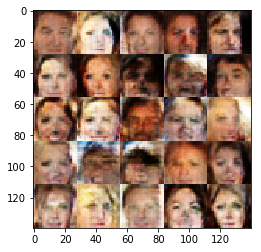

Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 3.2514
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.7413
Epoch 1/1... Discriminator Loss: 0.8011... Generator Loss: 2.8245
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 2.8926
Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 2.2808
Epoch 1/1... Discriminator Loss: 0.7168... Generator Loss: 1.9425
Epoch 1/1... Discriminator Loss: 0.7428... Generator Loss: 1.8839
Epoch 1/1... Discriminator Loss: 0.7234... Generator Loss: 1.4851
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 2.0403
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 2.5580


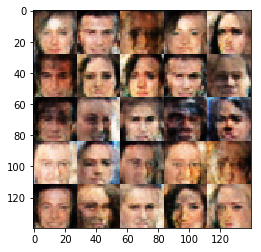

Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 1.2185
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 0.7458... Generator Loss: 1.6705
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 1.9367
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 1.6273
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.3264
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 0.9528


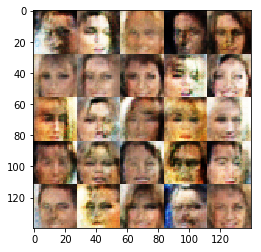

Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 1.2762
Epoch 1/1... Discriminator Loss: 0.7103... Generator Loss: 1.5933
Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 1.7199
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 2.1673
Epoch 1/1... Discriminator Loss: 0.7201... Generator Loss: 1.4580
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 0.7606... Generator Loss: 2.0288
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 3.3153
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 1.6793
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.7564


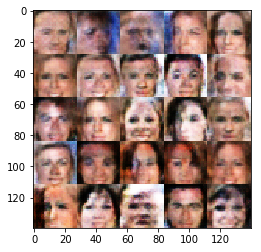

Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 2.0621
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 0.6724... Generator Loss: 2.6668
Epoch 1/1... Discriminator Loss: 0.7390... Generator Loss: 1.3927
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.1493
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 1.1567
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 1.9191


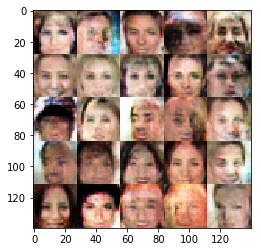

Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 0.7920... Generator Loss: 1.2370
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.4626
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 2.0565
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 1.2124


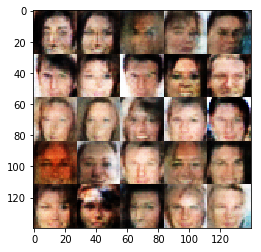

Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.3623
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.5087
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 3.5405
Epoch 1/1... Discriminator Loss: 1.9017... Generator Loss: 0.3071
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.3235
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 2.2393


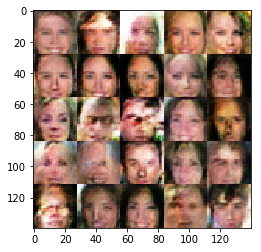

Epoch 1/1... Discriminator Loss: 0.7849... Generator Loss: 1.5908
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 2.1190
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 0.7861... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.6927
Epoch 1/1... Discriminator Loss: 0.9324... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 3.0084


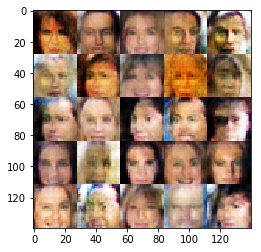

Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 1.5004
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.4573
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 1.4952
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 1.4844
Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.4103
Epoch 1/1... Discriminator Loss: 0.7409... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 1.3200
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 3.5119


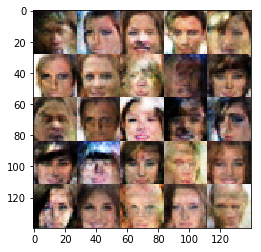

Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 2.3032
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.7831
Epoch 1/1... Discriminator Loss: 1.7987... Generator Loss: 3.8868
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 3.3834
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.1550
Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 1.6061
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.8167


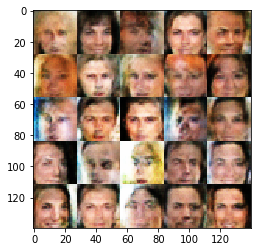

Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.4803
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.9596
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 3.1385
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.5298
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 0.6532... Generator Loss: 1.8526
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 2.7287


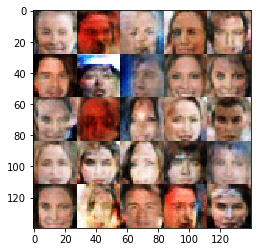

Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 1.2497
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 2.1213
Epoch 1/1... Discriminator Loss: 0.7603... Generator Loss: 1.6062
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 1.5408
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 1.1874
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 1.3995
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 1.2951
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 2.5763
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 0.7897


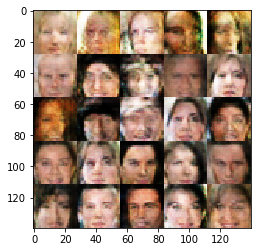

Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.3659
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 1.3629
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.2706
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 1.1130


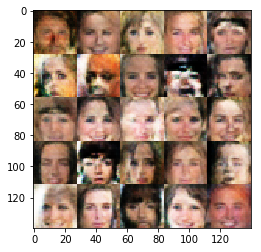

Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.5563
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 1.6936
Epoch 1/1... Discriminator Loss: 0.7374... Generator Loss: 1.8367
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.7324
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.2638
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.1689


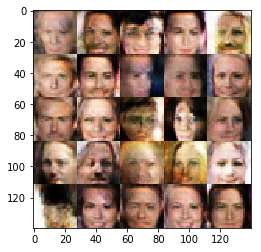

Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 2.1110
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 1.5606
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 3.6295
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 1.4313
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.1689


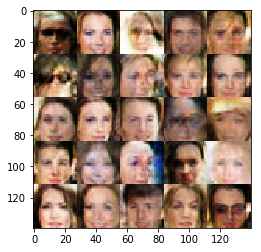

Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 2.6923
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 1.4683
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.2209
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.4258


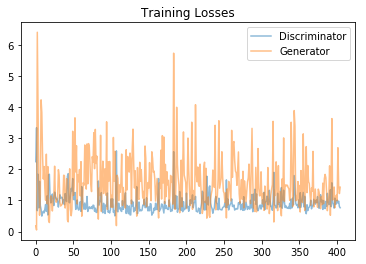

In [33]:
batch_size = 50
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.